In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

class_name = 'Occupancy'
df_training = pd.read_csv('training.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

df_test = pd.read_csv('test.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

columns2remove = ['date', 'Unnamed: 0', 'cumulative_hour', 'cumulative_minute', 'day']
df_training.drop(columns2remove, inplace=True, axis=1)
df_test.drop(columns2remove, inplace=True, axis=1)

df_training.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,hour,minute,day_minute,weekend
0,23.7000,26.272,585.200000,749.200000,0.004764,1,14,19,859,0
1,23.7180,26.290,578.400000,760.400000,0.004773,1,14,20,860,0
2,23.7300,26.230,572.666667,769.666667,0.004765,1,14,21,861,0
3,23.7225,26.125,493.750000,774.750000,0.004744,1,14,22,862,0
4,23.7540,26.200,488.600000,779.000000,0.004767,1,14,23,863,0


------

Normazation

In [2]:
from sklearn.preprocessing import StandardScaler

attributes = [col for col in df_training.columns if col != class_name]

#Primo tipo di normalizzazione: Z-Score 
scaler = StandardScaler()
X_train = scaler.fit_transform(df_training[attributes].values)
y_train = df_training[class_name]

X_test = scaler.fit_transform(df_test[attributes].values)
y_test = df_test[class_name]

-----

Looking for the best combination of features, using cross validation and grid search for each combination

In [3]:
%%time

from itertools import combinations
import operator #per trovare il numero cv migliore nel dizionario delle performance

tested_attributes = ['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio'] # elementi "fissi" che ci saranno ad ogni classificazione

summary = []
i=1

scaler = StandardScaler()
y_train = df_training[class_name]
y_test = df_test[class_name]

for r in range(2, 6):
    for attr in combinations(tested_attributes, r):
        # 'attr' è la combinazione di attributi da testare per ogni iterazione
        print("Attributes to test in iteration {}: {}".format(i, attr))
        X_train = scaler.fit_transform(df_training[list(attr)].values)
        X_test = scaler.fit_transform(df_test[list(attr)].values)
        
        #grid search per attr
        parameters = {'criterion': ['gini', 'entropy'],
                      'min_samples_split': [ 10, 15, 20, 30, 40 ,50 ,60 ,70,80 ,90 ,100 ,110,130, 150 , 170 ,190, 210],
                      'min_samples_leaf': [10, 15, 20 ,30, 35 ,40,45 ,50,55, 60, 65 ,70,80,100],}

        DT = DecisionTreeClassifier()
        search = GridSearchCV(DT, parameters, n_jobs = -1)
        search.fit(X_train, y_train)

        clf = search.best_estimator_
        for col, imp in zip(attr, clf.feature_importances_): #da aggiungere al dizionario
            print(col, imp)
        print("Best parameter for this attributes:", clf)

        #Cross validation per trovare il numero migliore di cv      
        cv_performances_f1 = {}
        cv_performances_acc = {}
        for k in range(3, 50):
            scores_acc = cross_val_score(clf, X_train, y_train, cv=k, n_jobs = -1)
            scores_f1 = cross_val_score(clf, X_train, y_train, cv=k, scoring='f1_macro', n_jobs = -1)
            cv_performances_f1[k] = scores_f1.mean()
            cv_performances_acc[k] = scores_acc.mean()
            
        best_performances_f1 = max(cv_performances_f1.items(), key=operator.itemgetter(1))[0]
        print("Best performance with cv = {}, f1-score = {}".format(best_performances_f1, cv_performances_f1[best_performances_f1]))
        print("Best performance with cv = {}, accuracy = {}".format(best_performances_f1, cv_performances_acc[best_performances_f1]))
        
        #classification on test set using best classifier for this iteration
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print()
        print('Accuracy %s' % accuracy_score(y_test, y_pred))
        print('F1-score %s' % f1_score(y_test, y_pred, average=None))
        print(classification_report(y_test, y_pred))
        report = classification_report(y_test, y_pred, output_dict=True)
        
        summary.append({'iteration' : i,
                    'attributes': attr,
                    'classificator': clf,
                    'cv': best_performances_f1,
                    'cv_accuracy' : cv_performances_acc[best_performances_f1],
                    'cv_f1': cv_performances_f1[best_performances_f1],
                    'test_accuracy' : accuracy_score(y_test, y_pred),
                    'f1-score [0]' : f1_score(y_test, y_pred, average=None)[0],
                    'f1-score [1]' : f1_score(y_test, y_pred, average=None)[1],
                    'precision [1]' : report['1']['precision'],
                    'recall [1]' : report['1']['recall']})
        print("---------------------------------------------------------\n\n\n")
        
        i+=1

rmance with cv = 45, accuracy = 0.8162939742250087

Accuracy 0.8521400778210116
F1-score [0.90703364 0.63895487]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5071
           1       0.56      0.74      0.64      1097

    accuracy                           0.85      6168
   macro avg       0.75      0.81      0.77      6168
weighted avg       0.87      0.85      0.86      6168

---------------------------------------------------------



Attributes to test in iteration 11: ('Temperature', 'Light', 'CO2')
Temperature 0.005330507877325916
Light 0.9904278648251965
CO2 0.004241627297477516
Best parameter for this attributes: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=190,
                

Plotting the tree for the best classificator

In [4]:
precisions = []

for i in range(len(summary)):
    precisions.append(float(summary[i]['precision [1]']))

#precision e summary hanno gli stessi indici
    
best_idx = precisions.index(max(precisions)) #index of the best classificator according to precision
summary[best_idx] #best classificator description

{'iteration': 5,
 'attributes': ('Light', 'CO2'),
 'classificator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=20, min_samples_split=150,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'cv': 37,
 'cv_accuracy': 0.9859652207795743,
 'cv_f1': 0.9827753148948648,
 'test_accuracy': 0.9969195849546044,
 'f1-score [0]': 0.9981234567901235,
 'f1-score [1]': 0.991406603346902,
 'precision [1]': 0.9838420107719928,
 'recall [1]': 0.9990884229717412}

In [5]:
import pydotplus
from sklearn import tree
from IPython.display import Image
import os

X_train = scaler.fit_transform(df_training[['Light', 'CO2']].values)
X_test = scaler.fit_transform(df_test[['Light', 'CO2']].values)

y_train = df_training[class_name]
y_test = df_test[class_name]

clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, min_samples_split=150, max_depth=3)
clf.fit(X_train, y_train)

os.environ['PATH'] += os.pathsep + 'C:/Users/dalla/Anaconda3/Library/bin/graphviz'

dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=['Lights', 'CO2'], 
                                class_names=['0', '1'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

fig = Image(graph.create_png(), format='jpeg')

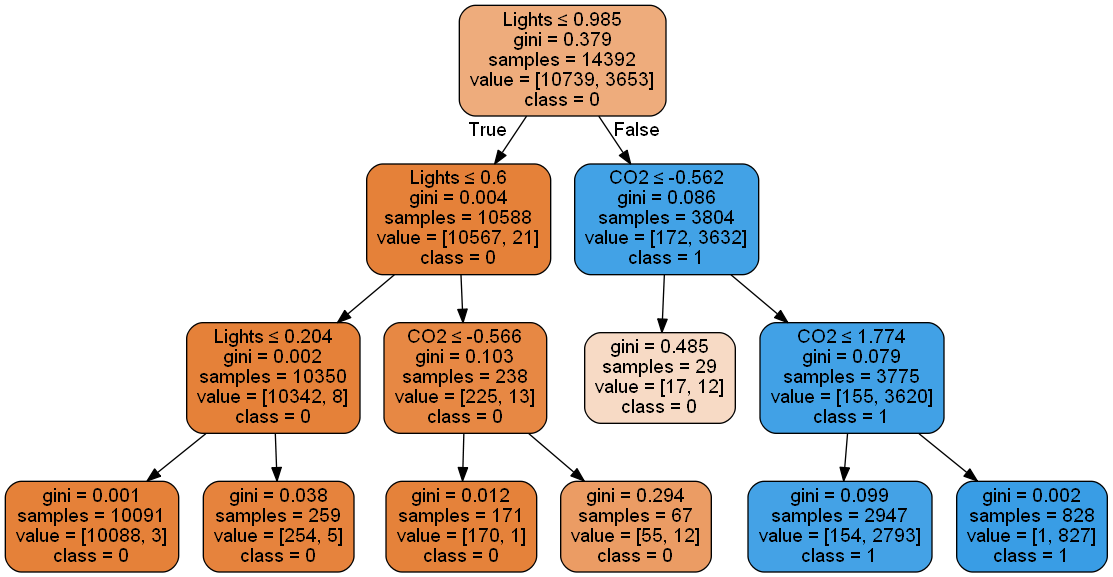

In [6]:
fig

In [7]:
#Proviamo il modello con tutte le variabili

X_train = scaler.fit_transform(df_training[['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio']].values)
X_test = scaler.fit_transform(df_test[['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio']].values)

y_train = df_training[class_name]
y_test = df_test[class_name]

# i parametri sono stati trovati dalla grid search, durante la prova di tutte le combinazioni di attributi
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=10, max_depth = 3)
clf.fit(X_train, y_train)

os.environ['PATH'] += os.pathsep + 'C:/Users/dalla/Anaconda3/Library/bin/graphviz'

dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio'], 
                                class_names=['0', '1'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

fig = Image(graph.create_png(), format='jpeg')

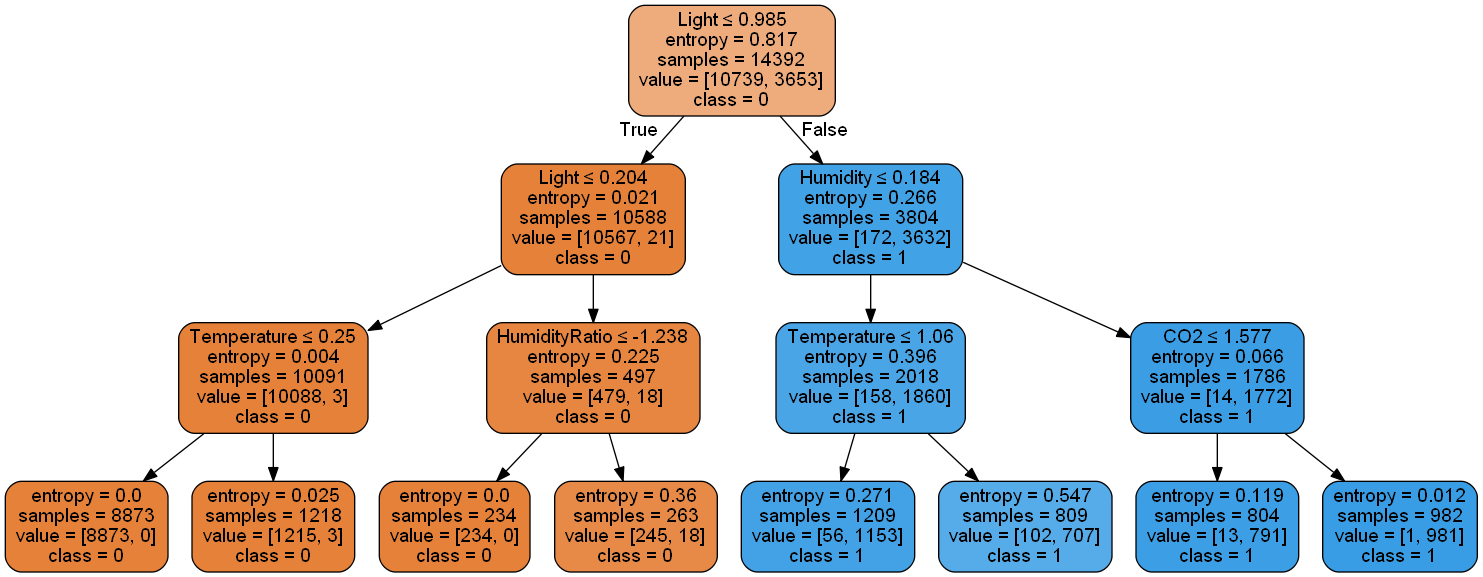

In [8]:
fig

In [ ]:
"""
Attributes to test in iteration 26: ('Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio')
Temperature 0.009852462089771703
Light 0.9660958617942869
CO2 0.010401417530805741
Humidity 0.008993778593274632
HumidityRatio 0.0046564799918609465
Best parameter for this attributes: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best performance with cv = 43, f1-score = 0.9768583077407306
Best performance with cv = 43, accuracy = 0.9819384486840271

Accuracy 0.9526588845654993
F1-score [0.97143975 0.86174242]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5071
           1       0.90      0.83      0.86      1097

    accuracy                           0.95      6168
   macro avg       0.93      0.90      0.92      6168
weighted avg       0.95      0.95      0.95      6168

---------------------------------------------------------
"""